In [1]:
# Cài đặt thư viện CatBoost (chỉ cần chạy 1 lần)
%pip install catboost -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from catboost import CatBoostRegressor, Pool, cv

import warnings
warnings.filterwarnings('ignore')

print("Import thư viện thành công!")

Import thư viện thành công!


In [3]:
# Đọc file dữ liệu
df = pd.read_csv('../data/global_disaster_response_2018_2024.csv')

# Xem thông tin cơ bản
print("Kích thước dữ liệu:", df.shape)
print("\nDanh sách các cột:")
print(df.columns.tolist())
print("\n5 dòng đầu tiên:")
df.head()

Kích thước dữ liệu: (50000, 12)

Danh sách các cột:
['date', 'country', 'disaster_type', 'severity_index', 'casualties', 'economic_loss_usd', 'response_time_hours', 'aid_amount_usd', 'response_efficiency_score', 'recovery_days', 'latitude', 'longitude']

5 dòng đầu tiên:


,date,country,disaster_type,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
0,31/1/2021,Brazil,Earthquake,5.99,111,7934365.71,15.62,271603.79,83.21,67,-30.613,-122.557
1,23/12/2018,Brazil,Extreme Heat,6.53,100,8307648.99,5.03,265873.81,96.18,55,10.859,-159.194
2,10/8/2020,India,Hurricane,1.55,22,765136.99,32.54,49356.49,60.40,22,0.643,-160.978
3,15/9/2022,Indonesia,Extreme Heat,4.55,94,1308251.31,7.83,237512.88,86.41,47,-33.547,30.350
4,28/9/2022,United States,Wildfire,3.80,64,2655864.36,21.90,188910.69,72.81,42,-19.170,-117.137


In [4]:
# Xem thông tin kiểu dữ liệu
print("Thông tin chi tiết:")
df.info()

print("\nThống kê mô tả:")
df.describe().round(2)

Thông tin chi tiết:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       50000 non-null  object 
 1   country                    50000 non-null  object 
 2   disaster_type              50000 non-null  object 
 3   severity_index             50000 non-null  float64
 4   casualties                 50000 non-null  int64  
 5   economic_loss_usd          50000 non-null  float64
 6   response_time_hours        50000 non-null  float64
 7   aid_amount_usd             50000 non-null  float64
 8   response_efficiency_score  50000 non-null  float64
 9   recovery_days              50000 non-null  int64  
 10  latitude                   50000 non-null  float64
 11  longitude                  50000 non-null  float64
dtypes: float64(7), int64(2), object(3)
memory usage: 4.6+ MB

Thống kê mô tả:


,severity_index,casualties,economic_loss_usd,response_time_hours,aid_amount_usd,response_efficiency_score,recovery_days,latitude,longitude
count,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00,50000.00
mean,5.02,100.59,5068593.45,12.18,250000.33,87.57,49.68,0.23,0.09
std,1.94,65.05,3268540.52,9.26,143227.51,10.19,20.10,34.76,98.38
min,1.00,0.00,527.39,1.00,16.60,29.75,2.00,-59.99,-170.00
25%,3.66,51.00,2585513.48,6.27,142966.34,83.06,36.00,-29.85,-85.55
50%,4.99,91.00,4548350.74,10.51,230536.47,89.18,49.00,0.27,0.39
75%,6.34,138.00,6950614.60,15.45,335225.93,94.70,63.00,30.49,85.66
max,10.00,524.00,24456237.87,63.10,1126465.23,100.00,112.00,60.00,170.00


In [5]:
# Kiểm tra dữ liệu thiếu (missing values)
print("Kiểm tra giá trị thiếu:")
missing = df.isnull().sum()
print(missing)

if missing.sum() == 0:
    print("\n=> Dữ liệu không có giá trị thiếu")

Kiểm tra giá trị thiếu:
date                         0
country                      0
disaster_type                0
severity_index               0
casualties                   0
economic_loss_usd            0
response_time_hours          0
aid_amount_usd               0
response_efficiency_score    0
recovery_days                0
latitude                     0
longitude                    0
dtype: int64

=> Dữ liệu không có giá trị thiếu


In [6]:
# Tạo bản sao dữ liệu để xử lý
df_processed = df.copy()

# Chuyển cột date sang kiểu datetime
df_processed['date'] = pd.to_datetime(df_processed['date'], format='%d/%m/%Y')

# Trích xuất năm và tháng từ cột date
df_processed['year'] = df_processed['date'].dt.year
df_processed['month'] = df_processed['date'].dt.month

print("Đã xử lý biến thời gian:")
print("- Năm:", df_processed['year'].min(), "-", df_processed['year'].max())
print("- Tháng: 1 - 12")

Đã xử lý biến thời gian:
- Năm: 2018 - 2024
- Tháng: 1 - 12


In [7]:
# Xác định các biến phân loại
categorical_features = ['country', 'disaster_type']

# Xem số lượng giá trị unique của mỗi biến
for col in categorical_features:
    print(f"{col}:")
    print(f"  - Số giá trị unique: {df_processed[col].nunique()}")
    print(f"  - Các giá trị: {df_processed[col].unique().tolist()}")

country:
  - Số giá trị unique: 20
  - Các giá trị: ['Brazil', 'India', 'Indonesia', 'United States', 'France', 'Germany', 'Greece', 'Spain', 'Mexico', 'South Africa', 'Philippines', 'Nigeria', 'Japan', 'Canada', 'Italy', 'Australia', 'China', 'Bangladesh', 'Chile', 'Turkey']
disaster_type:
  - Số giá trị unique: 10
  - Các giá trị: ['Earthquake', 'Extreme Heat', 'Hurricane', 'Wildfire', 'Flood', 'Storm Surge', 'Drought', 'Tornado', 'Landslide', 'Volcanic Eruption']


In [8]:
# Các biến cần log transform
log_transform_cols = ['economic_loss_usd', 'aid_amount_usd']

print("Log transformation:")
for col in log_transform_cols:
    # Tính skewness trước và sau khi transform
    skew_before = df_processed[col].skew()
    df_processed[f'{col}_log'] = np.log1p(df_processed[col])
    skew_after = df_processed[f'{col}_log'].skew()
    
    print(f"\n{col}:")
    print(f"  - Skewness trước: {skew_before:.3f}")
    print(f"  - Skewness sau: {skew_after:.3f}")

Log transformation:

economic_loss_usd:
  - Skewness trước: 0.922
  - Skewness sau: -1.737

aid_amount_usd:
  - Skewness trước: 0.810
  - Skewness sau: -1.579


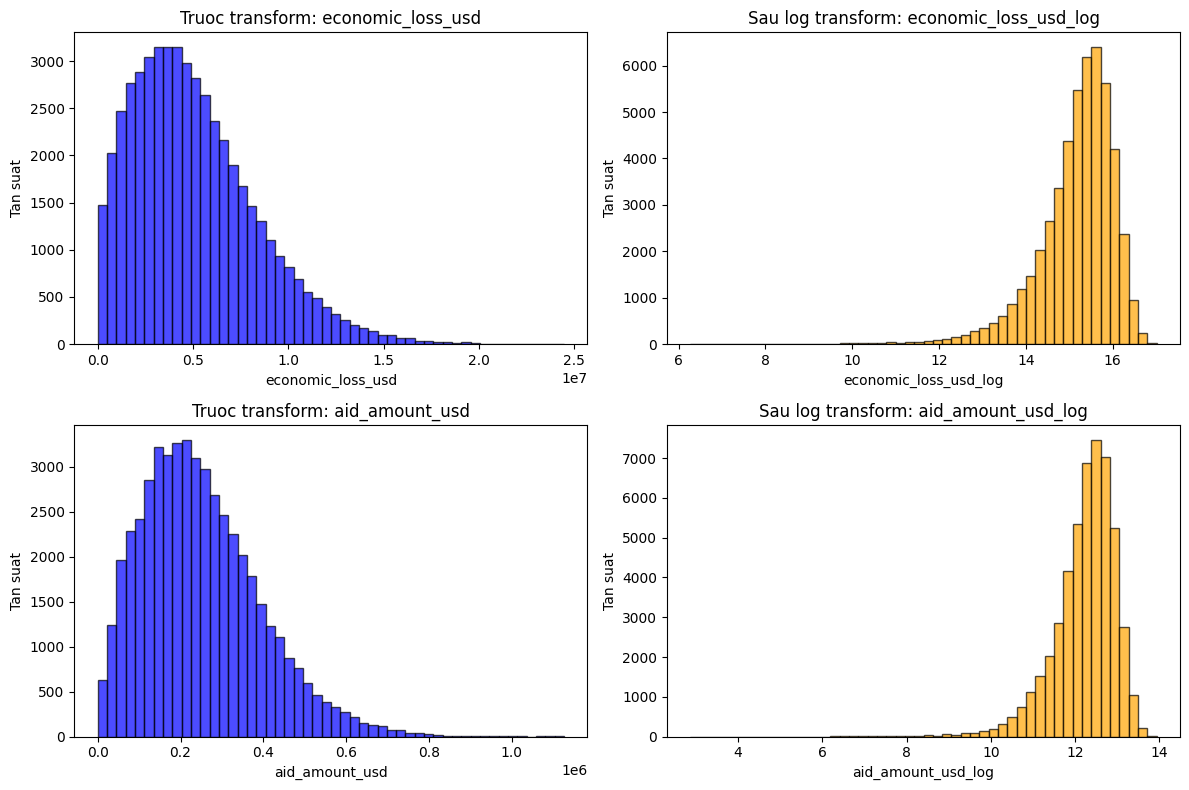

In [9]:
# Biểu đồ so sánh phân phối trước và sau log transform
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for idx, col in enumerate(log_transform_cols):
    # Phân phối gốc
    axes[idx, 0].hist(df_processed[col], bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[idx, 0].set_title(f'Truoc transform: {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Tan suat')
    
    # Phân phối sau log transform
    axes[idx, 1].hist(df_processed[f'{col}_log'], bins=50, color='orange', alpha=0.7, edgecolor='black')
    axes[idx, 1].set_title(f'Sau log transform: {col}_log')
    axes[idx, 1].set_xlabel(f'{col}_log')
    axes[idx, 1].set_ylabel('Tan suat')

plt.tight_layout()
plt.savefig('../models/log_transform_comparison.png', dpi=150)
plt.show()

In [10]:
# Tạo các đặc trưng mới
print("Tạo các đặc trưng mới:")

# 1. Thiệt hại kinh tế trên mỗi thương vong
df_processed['loss_per_casualty'] = df_processed['economic_loss_usd'] / (df_processed['casualties'] + 1)
print("1. loss_per_casualty = economic_loss_usd / (casualties + 1)")

# 2. Tiền viện trợ trên mỗi giờ phản ứng
df_processed['aid_per_hour'] = df_processed['aid_amount_usd'] / (df_processed['response_time_hours'] + 1)
print("2. aid_per_hour = aid_amount_usd / (response_time_hours + 1)")

# 3. Tỷ lệ mức độ nghiêm trọng / hiệu quả phản ứng
df_processed['severity_response_ratio'] = df_processed['severity_index'] / (df_processed['response_efficiency_score'] + 1) * 100
print("3. severity_response_ratio = severity_index / response_efficiency_score * 100")

# 4. Hiệu quả viện trợ
df_processed['aid_efficiency'] = df_processed['aid_amount_usd'] / (df_processed['economic_loss_usd'] + 1)
print("4. aid_efficiency = aid_amount_usd / economic_loss_usd")

print("\n=> Đã tạo 4 đặc trưng mới")

Tạo các đặc trưng mới:
1. loss_per_casualty = economic_loss_usd / (casualties + 1)
2. aid_per_hour = aid_amount_usd / (response_time_hours + 1)
3. severity_response_ratio = severity_index / response_efficiency_score * 100
4. aid_efficiency = aid_amount_usd / economic_loss_usd

=> Đã tạo 4 đặc trưng mới


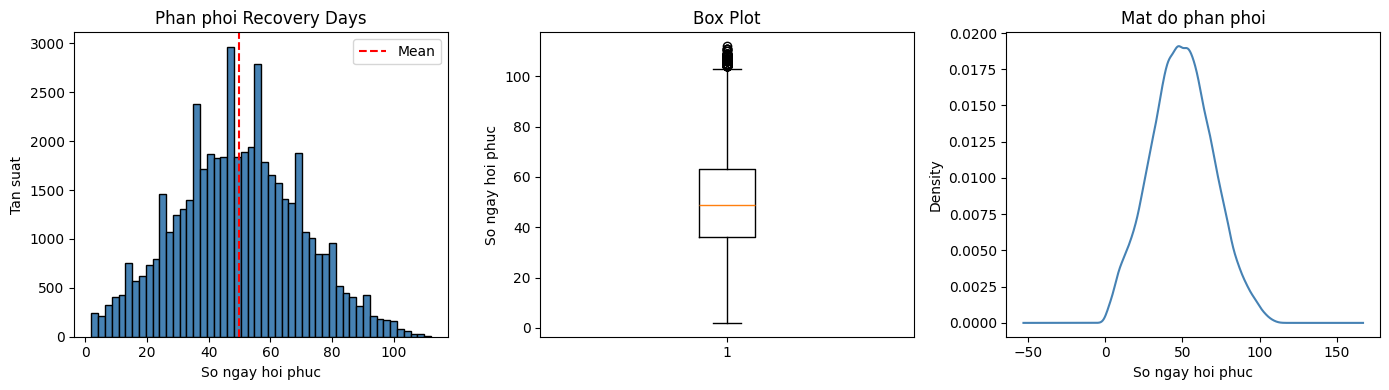

Thong ke bien muc tieu recovery_days:
  - Trung binh: 49.68 ngay
  - Trung vi: 49.00 ngay
  - Do lech chuan: 20.10 ngay
  - Min: 2 ngay
  - Max: 112 ngay


In [11]:
# Biểu đồ phân phối biến mục tiêu
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histogram
axes[0].hist(df_processed['recovery_days'], bins=50, color='steelblue', edgecolor='black')
axes[0].axvline(df_processed['recovery_days'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('So ngay hoi phuc')
axes[0].set_ylabel('Tan suat')
axes[0].set_title('Phan phoi Recovery Days')
axes[0].legend()

# Box plot
axes[1].boxplot(df_processed['recovery_days'])
axes[1].set_ylabel('So ngay hoi phuc')
axes[1].set_title('Box Plot')

# Density plot
df_processed['recovery_days'].plot(kind='kde', ax=axes[2], color='steelblue')
axes[2].set_xlabel('So ngay hoi phuc')
axes[2].set_title('Mat do phan phoi')

plt.tight_layout()
plt.savefig('../models/target_distribution.png', dpi=150)
plt.show()

# Thống kê mô tả
print("Thong ke bien muc tieu recovery_days:")
print(f"  - Trung binh: {df_processed['recovery_days'].mean():.2f} ngay")
print(f"  - Trung vi: {df_processed['recovery_days'].median():.2f} ngay")
print(f"  - Do lech chuan: {df_processed['recovery_days'].std():.2f} ngay")
print(f"  - Min: {df_processed['recovery_days'].min()} ngay")
print(f"  - Max: {df_processed['recovery_days'].max()} ngay")

In [12]:
# Danh sách các đặc trưng (features) sử dụng cho mô hình
feature_cols = [
    # Biến phân loại
    'country', 'disaster_type',
    
    # Biến số gốc
    'severity_index', 'casualties', 'response_time_hours', 
    'response_efficiency_score', 'latitude', 'longitude',
    
    # Biến đã log transform
    'economic_loss_usd_log', 'aid_amount_usd_log',
    
    # Biến thời gian
    'year', 'month',
    
    # Đặc trưng mới
    'loss_per_casualty', 'aid_per_hour', 'severity_response_ratio', 'aid_efficiency'
]

# Biến mục tiêu
target_col = 'recovery_days'

print(f"Tong so features: {len(feature_cols)}")
print("\nDanh sach features:")
for i, col in enumerate(feature_cols):
    ftype = "(categorical)" if col in categorical_features else "(numerical)"
    print(f"  {i+1}. {col} {ftype}")

Tong so features: 16

Danh sach features:
  1. country (categorical)
  2. disaster_type (categorical)
  3. severity_index (numerical)
  4. casualties (numerical)
  5. response_time_hours (numerical)
  6. response_efficiency_score (numerical)
  7. latitude (numerical)
  8. longitude (numerical)
  9. economic_loss_usd_log (numerical)
  10. aid_amount_usd_log (numerical)
  11. year (numerical)
  12. month (numerical)
  13. loss_per_casualty (numerical)
  14. aid_per_hour (numerical)
  15. severity_response_ratio (numerical)
  16. aid_efficiency (numerical)


In [13]:
# Tách features (X) và target (y)
X = df_processed[feature_cols].copy()
y = df_processed[target_col].copy()

# Chia dữ liệu thành tập train và test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Chia du lieu:")
print(f"  - Tap train: {X_train.shape[0]} mau ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"  - Tap test: {X_test.shape[0]} mau ({X_test.shape[0]/len(X)*100:.0f}%)")

Chia du lieu:
  - Tap train: 40000 mau (80%)
  - Tap test: 10000 mau (20%)


In [14]:
# Tạo CatBoost Pool (định dạng dữ liệu riêng của CatBoost)
train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=categorical_features
)

test_pool = Pool(
    data=X_test, 
    label=y_test, 
    cat_features=categorical_features
)

print("Da tao CatBoost Pool voi categorical features")

Da tao CatBoost Pool voi categorical features


In [15]:
# Khởi tạo mô hình CatBoost Regressor
model = CatBoostRegressor(
    iterations=1000,           # Số lượng cây tối đa
    learning_rate=0.05,        # Tốc độ học
    depth=8,                   # Độ sâu cây
    l2_leaf_reg=3,             # Hệ số regularization L2
    min_data_in_leaf=20,       # Số mẫu tối thiểu trong leaf node
    loss_function='RMSE',      # Hàm mất mát
    eval_metric='RMSE',        # Metric đánh giá
    random_seed=42,
    verbose=100                # In log mỗi 100 iterations
)

print("Cac tham so mo hinh:")
print("  - iterations: 1000")
print("  - learning_rate: 0.05")
print("  - depth: 8")
print("  - l2_leaf_reg: 3")
print("  - loss_function: RMSE")

Cac tham so mo hinh:
  - iterations: 1000
  - learning_rate: 0.05
  - depth: 8
  - l2_leaf_reg: 3
  - loss_function: RMSE


In [29]:
# Huấn luyện mô hình với early stopping
print("Bắt đầu huấn luyện CatBoost...\n")

model.fit(
    train_pool,
    eval_set=test_pool,
    early_stopping_rounds=50,  # Dừng nếu không cải thiện sau 50 rounds
    plot=False
)

print(f"\nHoàn thành huấn luyện!")
print(f"   - Best iteration: {model.best_iteration_}")
print(f"   - Best RMSE: {model.best_score_['validation']['RMSE']:.4f}")

Bắt đầu huấn luyện CatBoost...

0:	learn: 19.1985041	test: 19.2596270	best: 19.2596270 (0)	total: 83.8ms	remaining: 1m 23s
100:	learn: 5.0089388	test: 5.0302081	best: 5.0302081 (100)	total: 8.82s	remaining: 1m 18s
200:	learn: 4.9478844	test: 5.0216071	best: 5.0211975 (159)	total: 16.9s	remaining: 1m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 5.021197516
bestIteration = 159

Shrink model to first 160 iterations.

Hoàn thành huấn luyện!
   - Best iteration: 159
   - Best RMSE: 5.0212


In [30]:
# Dự đoán
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Hàm tính các metrics
def evaluate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name}:")
    print(f"   - MAE  (Mean Absolute Error): {mae:.4f} ngày")
    print(f"   - RMSE (Root Mean Squared Error): {rmse:.4f} ngày")
    print(f"   - R²   (R-squared Score): {r2:.4f}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

print("="*60)
print("KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH CATBOOST")
print("="*60)

train_metrics = evaluate_metrics(y_train, y_train_pred, "TẬP HUẤN LUYỆN (Train)")
test_metrics = evaluate_metrics(y_test, y_test_pred, "TẬP KIỂM TRA (Test)")

print("\n" + "="*60)
print(f"\nKết luận:")
print(f"   - Mô hình dự đoán sai trung bình {test_metrics['MAE']:.2f} ngày")
print(f"   - Mô hình giải thích được {test_metrics['R2']*100:.2f}% phương sai của dữ liệu")

KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH CATBOOST

TẬP HUẤN LUYỆN (Train):
   - MAE  (Mean Absolute Error): 3.9751 ngày
   - RMSE (Root Mean Squared Error): 4.9778 ngày
   - R²   (R-squared Score): 0.9386

TẬP KIỂM TRA (Test):
   - MAE  (Mean Absolute Error): 3.9971 ngày
   - RMSE (Root Mean Squared Error): 5.0212 ngày
   - R²   (R-squared Score): 0.9379


Kết luận:
   - Mô hình dự đoán sai trung bình 4.00 ngày
   - Mô hình giải thích được 93.79% phương sai của dữ liệu


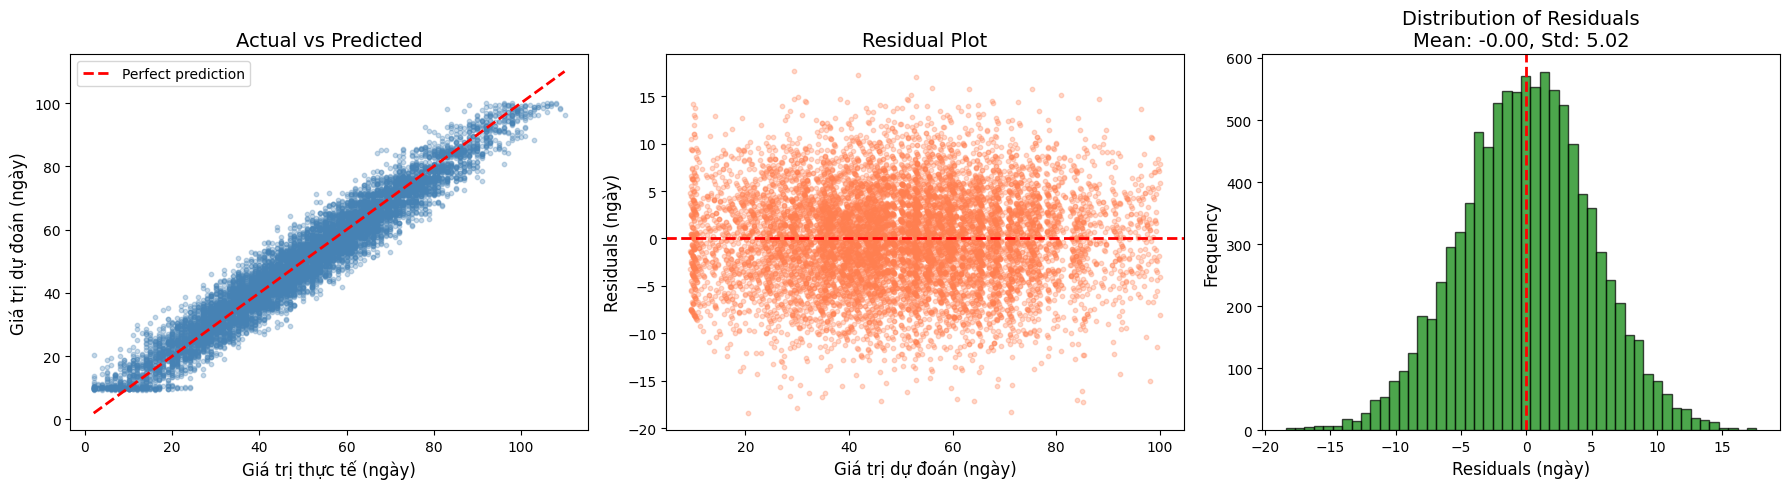

In [31]:
# Visualization: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.3, color='steelblue', s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Giá trị thực tế (ngày)', fontsize=12)
axes[0].set_ylabel('Giá trị dự đoán (ngày)', fontsize=12)
axes[0].set_title('Actual vs Predicted', fontsize=14)
axes[0].legend()

# 2. Residual plot
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.3, color='coral', s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Giá trị dự đoán (ngày)', fontsize=12)
axes[1].set_ylabel('Residuals (ngày)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14)

# 3. Distribution of residuals
axes[2].hist(residuals, bins=50, edgecolor='black', color='green', alpha=0.7)
axes[2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[2].set_xlabel('Residuals (ngày)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title(f'Distribution of Residuals\nMean: {residuals.mean():.2f}, Std: {residuals.std():.2f}', fontsize=14)

plt.tight_layout()
plt.show()

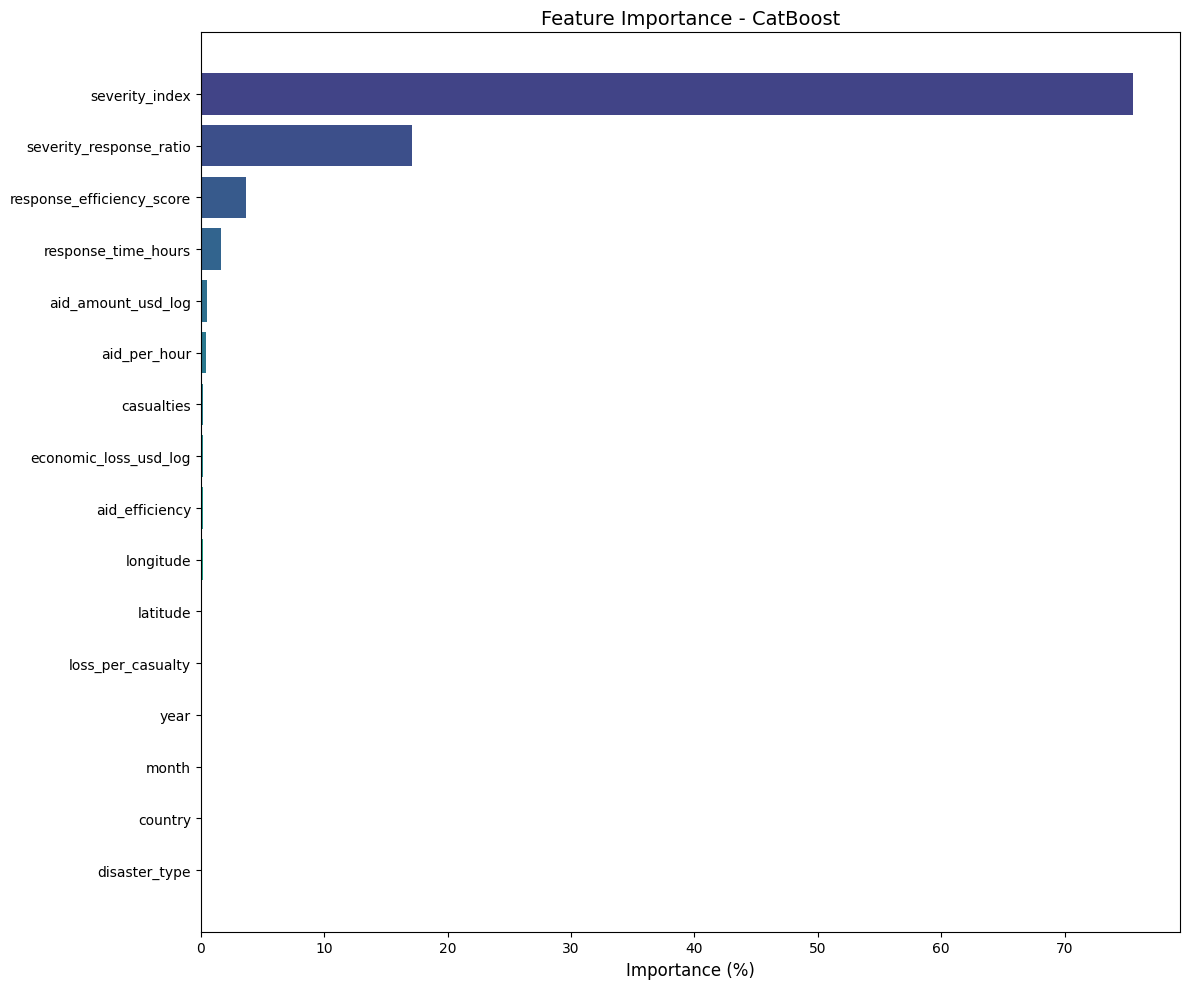


Top 10 đặc trưng quan trọng nhất:
               Feature Id  Importances
           severity_index    75.568209
  severity_response_ratio    17.080255
response_efficiency_score     3.635565
      response_time_hours     1.609370
       aid_amount_usd_log     0.485915
             aid_per_hour     0.417018
               casualties     0.176147
    economic_loss_usd_log     0.172116
           aid_efficiency     0.152403
                longitude     0.147510


In [32]:
# Feature Importance từ CatBoost
feature_importance = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'], color=colors)
plt.xlabel('Importance (%)', fontsize=12)
plt.title('Feature Importance - CatBoost', fontsize=14)
plt.gca().invert_yaxis()  # Quan trọng nhất ở trên
plt.tight_layout()
plt.show()

print("\nTop 10 đặc trưng quan trọng nhất:")
print(feature_importance.head(10).to_string(index=False))

In [ ]:
# Cross-validation với CatBoost
from catboost import cv
# Tạo Pool từ toàn bộ dữ liệu
full_pool = Pool(data=X, label=y, cat_features=categorical_features)

# Thực hiện 5-fold cross-validation
print("Thực hiện 5-Fold Cross-Validation...\n")

cv_params = model.get_params()
cv_params['iterations'] = model.best_iteration_  # Sử dụng best iteration

cv_results = cv(
    pool=full_pool,
    params=cv_params,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    verbose=False
)

print("\nKẾT QUẢ CROSS-VALIDATION (5-Fold):")
print("="*50)
final_rmse_mean = cv_results['test-RMSE-mean'].iloc[-1]
final_rmse_std = cv_results['test-RMSE-std'].iloc[-1]
print(f"   - RMSE: {final_rmse_mean:.4f} ± {final_rmse_std:.4f}")
print("="*50)

Thực hiện 5-Fold Cross-Validation...

Training on fold [0/5]

bestTest = 5.066663299
bestIteration = 158

Training on fold [1/5]

bestTest = 5.108794248
bestIteration = 158

Training on fold [2/5]

bestTest = 5.006384224
bestIteration = 158

Training on fold [3/5]

bestTest = 5.078990926
bestIteration = 158

Training on fold [4/5]

bestTest = 5.001403355
bestIteration = 158


KẾT QUẢ CROSS-VALIDATION (5-Fold):
   - RMSE: 5.0524 ± 0.0469


In [35]:
# Class dự đoán số ngày hồi phục
class RecoveryDaysPredictor:
    def __init__(self, model, feature_cols, categorical_features):
        self.model = model
        self.feature_cols = feature_cols
        self.categorical_features = categorical_features
    
    def preprocess(self, disaster_data):
        """
        Tiền xử lý dữ liệu đầu vào.
        """
        df_input = pd.DataFrame([disaster_data])
        
        # Log-transform
        df_input['economic_loss_usd_log'] = np.log1p(df_input['economic_loss_usd'])
        df_input['aid_amount_usd_log'] = np.log1p(df_input['aid_amount_usd'])
        
        # Feature engineering
        df_input['loss_per_casualty'] = df_input['economic_loss_usd'] / (df_input['casualties'] + 1)
        df_input['aid_per_hour'] = df_input['aid_amount_usd'] / (df_input['response_time_hours'] + 1)
        df_input['severity_response_ratio'] = df_input['severity_index'] / (df_input['response_efficiency_score'] + 1) * 100
        df_input['aid_efficiency'] = df_input['aid_amount_usd'] / (df_input['economic_loss_usd'] + 1)
        
        return df_input[self.feature_cols]
    
    def predict(self, disaster_data):
        """
        Dự đoán số ngày hồi phục.
        """
        X_input = self.preprocess(disaster_data)
        prediction = self.model.predict(X_input)[0]
        return max(1, round(prediction, 1))  # Tối thiểu 1 ngày

# Khởi tạo predictor
predictor = RecoveryDaysPredictor(model, feature_cols, categorical_features)
print(" Hệ thống dự đoán đã sẵn sàng!")

 Hệ thống dự đoán đã sẵn sàng!


In [36]:
# Các quốc gia và loại thảm họa có trong dữ liệu
print("Danh sách quốc gia có trong dữ liệu:")
print(sorted(df['country'].unique()))
print("\nDanh sách loại thảm họa:")
print(sorted(df['disaster_type'].unique()))

Danh sách quốc gia có trong dữ liệu:
['Australia', 'Bangladesh', 'Brazil', 'Canada', 'Chile', 'China', 'France', 'Germany', 'Greece', 'India', 'Indonesia', 'Italy', 'Japan', 'Mexico', 'Nigeria', 'Philippines', 'South Africa', 'Spain', 'Turkey', 'United States']

Danh sách loại thảm họa:
['Drought', 'Earthquake', 'Extreme Heat', 'Flood', 'Hurricane', 'Landslide', 'Storm Surge', 'Tornado', 'Volcanic Eruption', 'Wildfire']


In [37]:
# Ví dụ 1: Động đất tại Japan
disaster_example_1 = {
    'country': 'Japan',
    'disaster_type': 'Earthquake',
    'severity_index': 7.5,
    'casualties': 150,
    'economic_loss_usd': 5000000,
    'response_time_hours': 8,
    'aid_amount_usd': 300000,
    'response_efficiency_score': 85,
    'latitude': 35.6762,
    'longitude': 139.6503,
    'year': 2024,
    'month': 6
}

prediction_1 = predictor.predict(disaster_example_1)
print("VÍ DỤ 1: Động đất tại Japan")
print(f"   - Mức độ nghiêm trọng: {disaster_example_1['severity_index']}")
print(f"   - Số thương vong: {disaster_example_1['casualties']}")
print(f"   - Thiệt hại kinh tế: ${disaster_example_1['economic_loss_usd']:,}")
print(f"   - Thời gian phản ứng: {disaster_example_1['response_time_hours']} giờ")
print(f"   DỰ ĐOÁN SỐ NGÀY HỒI PHỤC: {prediction_1} ngày")

VÍ DỤ 1: Động đất tại Japan
   - Mức độ nghiêm trọng: 7.5
   - Số thương vong: 150
   - Thiệt hại kinh tế: $5,000,000
   - Thời gian phản ứng: 8 giờ
   DỰ ĐOÁN SỐ NGÀY HỒI PHỤC: 74.9 ngày


In [38]:
# Ví dụ 2: Bão tại Philippines
disaster_example_2 = {
    'country': 'Philippines',
    'disaster_type': 'Hurricane',
    'severity_index': 8.2,
    'casualties': 200,
    'economic_loss_usd': 8000000,
    'response_time_hours': 12,
    'aid_amount_usd': 500000,
    'response_efficiency_score': 75,
    'latitude': 14.5995,
    'longitude': 120.9842,
    'year': 2024,
    'month': 9
}

prediction_2 = predictor.predict(disaster_example_2)
print("VÍ DỤ 2: Bão tại Philippines")
print(f"   - Mức độ nghiêm trọng: {disaster_example_2['severity_index']}")
print(f"   - Số thương vong: {disaster_example_2['casualties']}")
print(f"   - Thiệt hại kinh tế: ${disaster_example_2['economic_loss_usd']:,}")
print(f"   - Thời gian phản ứng: {disaster_example_2['response_time_hours']} giờ")
print(f"   DỰ ĐOÁN SỐ NGÀY HỒI PHỤC: {prediction_2} ngày")

VÍ DỤ 2: Bão tại Philippines
   - Mức độ nghiêm trọng: 8.2
   - Số thương vong: 200
   - Thiệt hại kinh tế: $8,000,000
   - Thời gian phản ứng: 12 giờ
   DỰ ĐOÁN SỐ NGÀY HỒI PHỤC: 80.5 ngày


In [39]:
# Ví dụ 3: Lũ lụt tại India
disaster_example_3 = {
    'country': 'India',
    'disaster_type': 'Flood',
    'severity_index': 5.5,
    'casualties': 80,
    'economic_loss_usd': 3000000,
    'response_time_hours': 15,
    'aid_amount_usd': 200000,
    'response_efficiency_score': 70,
    'latitude': 20.5937,
    'longitude': 78.9629,
    'year': 2024,
    'month': 7
}

prediction_3 = predictor.predict(disaster_example_3)
print("VÍ DỤ 3: Lũ lụt tại India")
print(f"   - Mức độ nghiêm trọng: {disaster_example_3['severity_index']}")
print(f"   - Số thương vong: {disaster_example_3['casualties']}")
print(f"   - Thiệt hại kinh tế: ${disaster_example_3['economic_loss_usd']:,}")
print(f"   - Thời gian phản ứng: {disaster_example_3['response_time_hours']} giờ")
print(f"   DỰ ĐOÁN SỐ NGÀY HỒI PHỤC: {prediction_3} ngày")

VÍ DỤ 3: Lũ lụt tại India
   - Mức độ nghiêm trọng: 5.5
   - Số thương vong: 80
   - Thiệt hại kinh tế: $3,000,000
   - Thời gian phản ứng: 15 giờ
   DỰ ĐOÁN SỐ NGÀY HỒI PHỤC: 55.4 ngày


In [40]:
# ============================================
# NHẬP THÔNG TIN THẢM HỌA MỚI TẠI ĐÂY
# ============================================

my_disaster = {
    'country': 'Brazil',            # Quốc gia
    'disaster_type': 'Flood',       # Loại thảm họa
    'severity_index': 6.5,          # Mức độ nghiêm trọng (0-10)
    'casualties': 120,              # Số thương vong
    'economic_loss_usd': 5500000,   # Thiệt hại kinh tế (USD)
    'response_time_hours': 10,      # Thời gian phản ứng (giờ)
    'aid_amount_usd': 350000,       # Số tiền viện trợ (USD)
    'response_efficiency_score': 78, # Điểm hiệu quả phản ứng (0-100)
    'latitude': -15.7801,           # Vĩ độ
    'longitude': -47.9292,          # Kinh độ
    'year': 2024,                   # Năm
    'month': 11                     # Tháng
}

# Thực hiện dự đoán
my_prediction = predictor.predict(my_disaster)

print("\n" + "="*60)
print("KẾT QUẢ DỰ ĐOÁN")
print("="*60)
print(f"Quốc gia: {my_disaster['country']}")
print(f"Loại thảm họa: {my_disaster['disaster_type']}")
print(f"Mức độ nghiêm trọng: {my_disaster['severity_index']}/10")
print(f"Số thương vong: {my_disaster['casualties']:,}")
print(f"Thiệt hại kinh tế: ${my_disaster['economic_loss_usd']:,}")
print(f"Thời gian phản ứng: {my_disaster['response_time_hours']} giờ")
print(f"Tiền viện trợ: ${my_disaster['aid_amount_usd']:,}")
print(f"Hiệu quả phản ứng: {my_disaster['response_efficiency_score']}/100")
print("="*60)
print(f"\nDỰ ĐOÁN SỐ NGÀY HỒI PHỤC: {my_prediction} NGÀY")
print("="*60)


KẾT QUẢ DỰ ĐOÁN
Quốc gia: Brazil
Loại thảm họa: Flood
Mức độ nghiêm trọng: 6.5/10
Số thương vong: 120
Thiệt hại kinh tế: $5,500,000
Thời gian phản ứng: 10 giờ
Tiền viện trợ: $350,000
Hiệu quả phản ứng: 78/100

DỰ ĐOÁN SỐ NGÀY HỒI PHỤC: 64.6 NGÀY


## 11. Lưu mô hình

In [41]:
import os

# Tạo thư mục models nếu chưa có
os.makedirs('../models', exist_ok=True)

# Lưu mô hình CatBoost
model.save_model('../models/catboost_recovery_days.cbm')

# Lưu feature list
import json
config = {
    'feature_cols': feature_cols,
    'categorical_features': categorical_features,
    'train_metrics': train_metrics,
    'test_metrics': test_metrics
}

with open('../models/catboost_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Đã lưu mô hình tại:")
print("   - ../models/catboost_recovery_days.cbm")
print("   - ../models/catboost_config.json")

Đã lưu mô hình tại:
   - ../models/catboost_recovery_days.cbm
   - ../models/catboost_config.json


In [43]:
# Cách tải lại mô hình để sử dụng
print(" Code để tải lại mô hình:")
print("""
from catboost import CatBoostRegressor
import json

# Tải mô hình
model = CatBoostRegressor()
model.load_model('../models/catboost_recovery_days.cbm')

# Tải config
with open('../models/catboost_config.json', 'r') as f:
    config = json.load(f)

feature_cols = config['feature_cols']
categorical_features = config['categorical_features']
""")

 Code để tải lại mô hình:

from catboost import CatBoostRegressor
import json

# Tải mô hình
model = CatBoostRegressor()
model.load_model('../models/catboost_recovery_days.cbm')

# Tải config
with open('../models/catboost_config.json', 'r') as f:
    config = json.load(f)

feature_cols = config['feature_cols']
categorical_features = config['categorical_features']

